In [ ]:
!pip install pandas_market_calendars


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
raw = pd.read_parquet("/content/data.parquet", engine="pyarrow")


In [ ]:
print("Shape of dataset (rows, columns):", raw.shape)
print("\nColumn names:\n", raw.columns.tolist())
print("\nFirst 5 rows:")
display(raw.head())
print("\nLast 5 rows:")
display(raw.tail())
print("\nInfo about dataset:")
print(raw.info())
print("\nSummary stats:")
display(raw.describe(include='all').T)
print("\nMissing values per column:")
print(raw.isna().sum())


Shape of dataset (rows, columns): (690512, 3)

Column names:
 ['banknifty', 'nifty', 'tte']

First 5 rows:


,banknifty,nifty,tte
time,,,
2021-01-01 09:15:00,0.286058,0.199729,27
2021-01-01 09:16:00,0.285381,0.200433,27
2021-01-01 09:17:00,0.284233,0.200004,27
2021-01-01 09:18:00,0.286104,0.199860,27
2021-01-01 09:19:00,0.285539,0.198951,27



Last 5 rows:


,banknifty,nifty,tte
time,,,
2022-06-30 15:26:00,0.240701,0.214758,28
2022-06-30 15:27:00,0.240875,0.216558,28
2022-06-30 15:28:00,0.242115,0.216794,28
2022-06-30 15:29:00,0.243426,0.216455,28
2022-06-30 15:30:00,0.241907,0.216081,28



Info about dataset:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 690512 entries, 2021-01-01 09:15:00 to 2022-06-30 15:30:00
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   banknifty  689012 non-null  float64
 1   nifty      688512 non-null  float64
 2   tte        690512 non-null  int32  
dtypes: float64(2), int32(1)
memory usage: 18.4 MB
None

Summary stats:


,count,mean,std,min,25%,50%,75%,max
banknifty,689012.0,0.250156,0.057702,0.152732,0.205307,0.243977,0.295293,0.460619
nifty,688512.0,0.179343,0.046139,0.089355,0.140375,0.181210,0.215635,0.306952
tte,690512.0,15.671884,8.664597,2.000000,8.000000,15.000000,23.000000,31.000000



Missing values per column:
banknifty    1500
nifty        2000
tte             0
dtype: int64


In [ ]:
import pandas_market_calendars as pmc
nse = pmc.get_calendar("XNSE")
schedule = nse.schedule(start_date=raw.index.min().date(),
                        end_date=raw.index.max().date())
print("Trading days in calendar:", len(schedule))


Trading days in calendar: 370


In [ ]:
valid_days = schedule.index
raw = raw[raw.index.normalize().isin(valid_days)]


In [ ]:
raw = raw[~raw.index.duplicated()].sort_index()


In [ ]:
print("Earliest timestamp in day:", raw.index[0].time())
print("Latest timestamp in day:", raw.index[-1].time())


Earliest timestamp in day: 09:15:00
Latest timestamp in day: 15:30:00


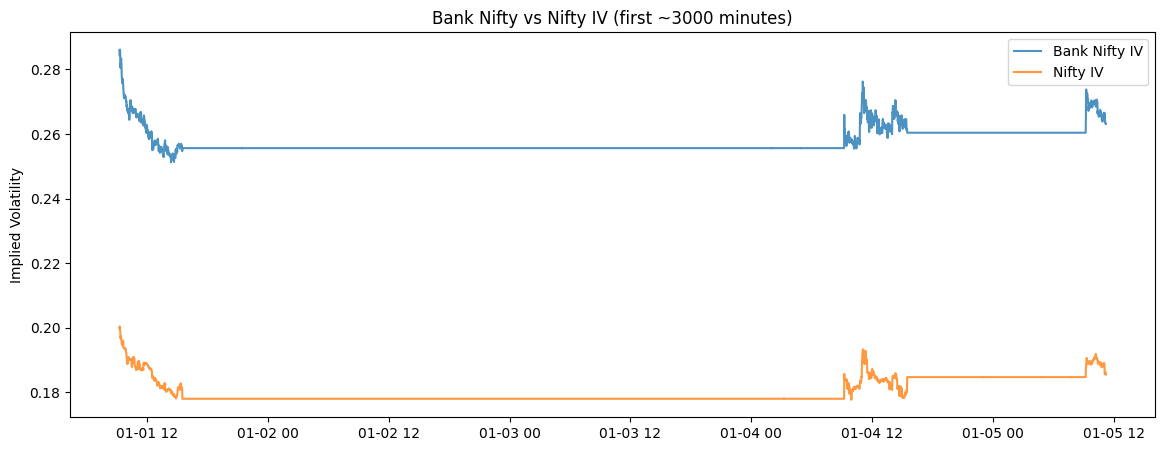

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(raw.index[:3000], raw['banknifty'].iloc[:3000], label="Bank Nifty IV", alpha=0.8)
plt.plot(raw.index[:3000], raw['nifty'].iloc[:3000], label="Nifty IV", alpha=0.8)
plt.legend()
plt.title("Bank Nifty vs Nifty IV (first ~3000 minutes)")
plt.ylabel("Implied Volatility")
plt.show()


In [ ]:
print("---- BEFORE (missing values) ----")
print(raw.isna().sum())
print("Head:\n", raw.head(3))
print("Tail:\n", raw.tail(3))


---- BEFORE (missing values) ----
banknifty    1012
nifty        1373
tte             0
dtype: int64
Head:
                      banknifty     nifty  tte
time                                         
2021-01-01 09:15:00   0.286058  0.199729   27
2021-01-01 09:16:00   0.285381  0.200433   27
2021-01-01 09:17:00   0.284233  0.200004   27
Tail:
                      banknifty     nifty  tte
time                                         
2022-06-30 15:28:00   0.242115  0.216794   28
2022-06-30 15:29:00   0.243426  0.216455   28
2022-06-30 15:30:00   0.241907  0.216081   28


In [ ]:
gaps = raw.index.to_series().diff().dt.total_seconds().div(60).fillna(1)
print("\nGap size stats (minutes):")
print(gaps.describe())



Gap size stats (minutes):
count    470192.000000
mean          1.669905
std         143.056539
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max       94665.000000
Name: time, dtype: float64


In [ ]:
df = raw.copy()


In [ ]:
gap_min = df.index.to_series().diff().dt.total_seconds().div(60).fillna(1.0)
df['gap_min'] = gap_min


In [ ]:
df['gap_flag'] = 'small'
df.loc[df['gap_min'] > 3, 'gap_flag'] = 'large'


In [ ]:
print("Gap summary (minutes):")
print(gap_min.describe())
print("\nGap counts by type:")
print(df['gap_flag'].value_counts())


Gap summary (minutes):
count    470192.000000
mean          1.669905
std         143.056539
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max       94665.000000
Name: time, dtype: float64

Gap counts by type:
gap_flag
small    470113
large        79
Name: count, dtype: int64


In [ ]:
print("Large gap rows that had NaNs:")
print(df.loc[(df['gap_flag']=="large") & (df[['banknifty','nifty']].isna().any(axis=1))])


Large gap rows that had NaNs:
Empty DataFrame
Columns: [banknifty, nifty, tte, gap_min, gap_flag]
Index: []


In [ ]:
print("---- BEFORE fill: missing counts ----")
print(df[['banknifty','nifty']].isna().sum())
print("\nSample rows around a known NA (if any):")
na_rows = df[df[['banknifty','nifty']].isna().any(axis=1)].head(3).index
display(df.loc[na_rows].head(5) if len(na_rows) else "No immediate NA sample to show")


---- BEFORE fill: missing counts ----
banknifty    1012
nifty        1373
dtype: int64

Sample rows around a known NA (if any):


,banknifty,nifty,tte,gap_min,gap_flag
time,,,,,
2021-01-01 12:39:00,0.25685,NaN,27,1.0,small
2021-01-01 21:25:00,NaN,0.178049,27,1.0,small
2021-01-04 02:01:00,NaN,0.178049,27,1.0,small


In [ ]:
to_fill_mask = (df['gap_flag'] == 'small')
clean = df.copy()
ffilled = clean[['banknifty','nifty']].ffill()
clean.loc[to_fill_mask, ['banknifty','nifty']] = ffilled.loc[to_fill_mask, ['banknifty','nifty']]
for col in ['banknifty','nifty']:
    clean[f'{col}_changed_by_ffill'] = (~clean[col].eq(df[col])) & to_fill_mask
print("---- AFTER fill: missing counts ----")
print(clean[['banknifty','nifty']].isna().sum())
print("\nCounts changed by ffill (per column):")
print(clean[['banknifty_changed_by_ffill','nifty_changed_by_ffill']].sum())


---- AFTER fill: missing counts ----
banknifty    0
nifty        0
dtype: int64

Counts changed by ffill (per column):
banknifty_changed_by_ffill    1012
nifty_changed_by_ffill        1373
dtype: int64


IV quantiles BEFORE clipping:
        banknifty     nifty
0.001   0.155612  0.099999
0.010   0.162214  0.103063
0.500   0.244750  0.181429
0.990   0.386126  0.275550
0.999   0.421067  0.287172

Hard min/max BEFORE clipping:
     banknifty     nifty
min   0.152732  0.089355
max   0.460619  0.306952


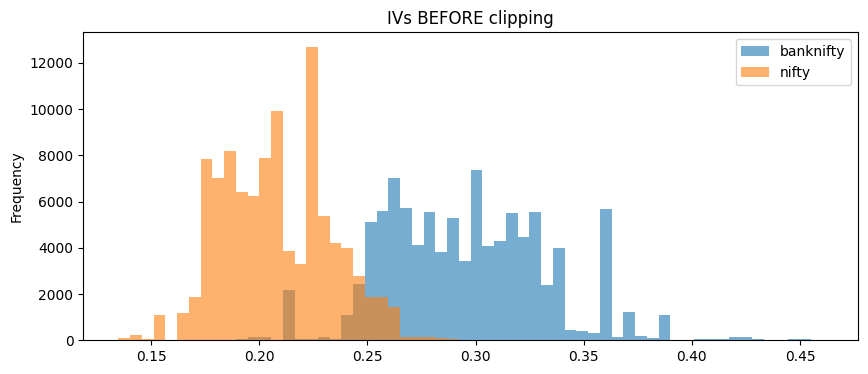

In [ ]:
q = clean[['banknifty','nifty']].quantile([0.001, 0.01, 0.5, 0.99, 0.999])
print("IV quantiles BEFORE clipping:\n", q)
print("\nHard min/max BEFORE clipping:")
print(clean[['banknifty','nifty']].agg(['min','max']))
_ = clean[['banknifty','nifty']].head(100_000).plot(kind='hist', bins=60, alpha=0.6, figsize=(10,4), title="IVs BEFORE clipping")


In [ ]:
features = clean.copy()


In [ ]:
features['spread'] = features['banknifty'] - features['nifty']


In [ ]:
features['V'] = features['spread'] * (features['tte'] ** 0.7)
display(features[['banknifty','nifty','tte','spread','V']].head())


,banknifty,nifty,tte,spread,V
time,,,,,
2021-01-01 09:15:00,0.286058,0.199729,27,0.086329,0.867184
2021-01-01 09:16:00,0.285381,0.200433,27,0.084948,0.853317
2021-01-01 09:17:00,0.284233,0.200004,27,0.084229,0.846089
2021-01-01 09:18:00,0.286104,0.199860,27,0.086244,0.866325
2021-01-01 09:19:00,0.285539,0.198951,27,0.086588,0.869786


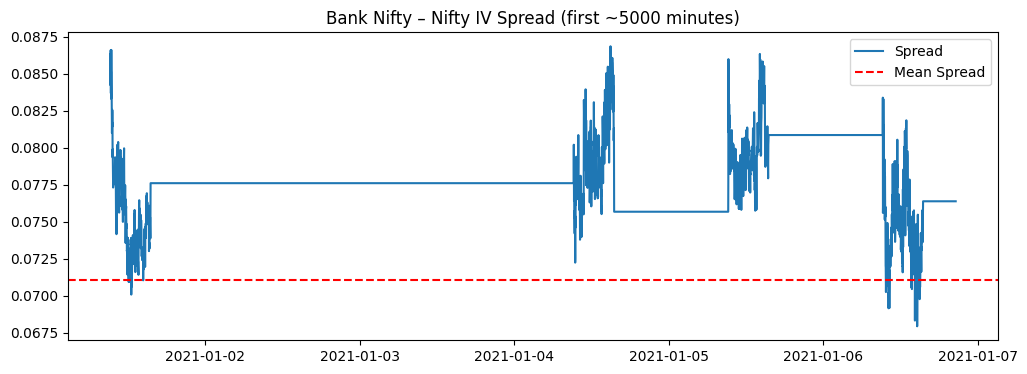

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(features.index[:5000], features['spread'].iloc[:5000], label="Spread")
plt.axhline(features['spread'].mean(), color="red", linestyle="--", label="Mean Spread")
plt.title("Bank Nifty – Nifty IV Spread (first ~5000 minutes)")
plt.legend()
plt.show()


Share of negative spread rows: 3.402865212508933e-05
Mean/Std: 0.07107915807138361 0.025979499710820912


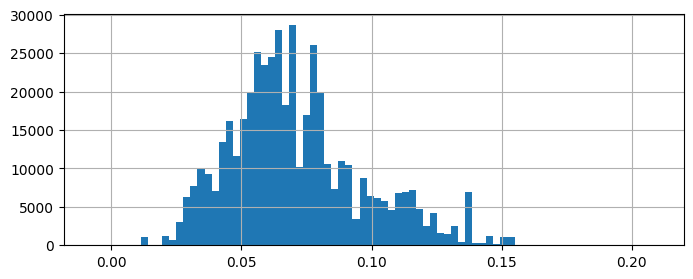

In [ ]:
features['spread'].hist(bins=80, figsize=(8,3))
print("Share of negative spread rows:", (features['spread'] < 0).mean())
print("Mean/Std:", features['spread'].mean(), features['spread'].std())


Text(0.5, 1.0, 'Rolling mean/std of spread')

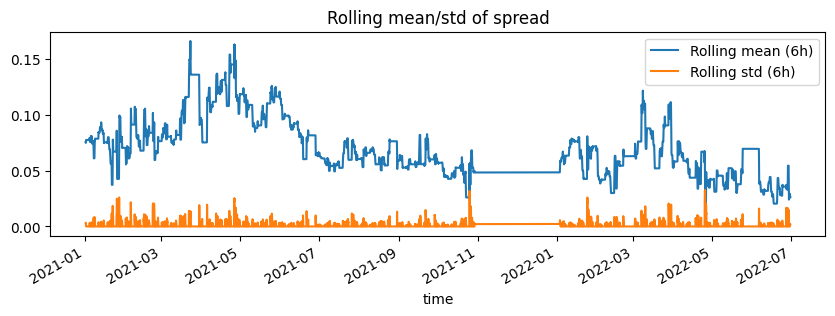

In [ ]:
roll = features['spread'].rolling(6*60)
ax = roll.mean().plot(figsize=(10,3), label='Rolling mean (6h)')
roll.std().plot(ax=ax, label='Rolling std (6h)')
ax.legend(); ax.set_title("Rolling mean/std of spread")


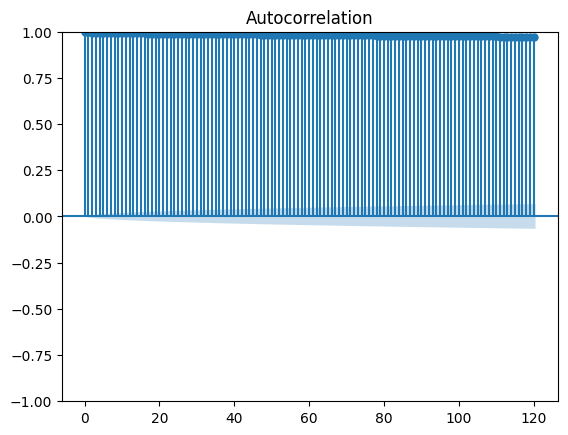

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(features['spread'].dropna().values[:200000], lags=120, fft=True)
plt.show()


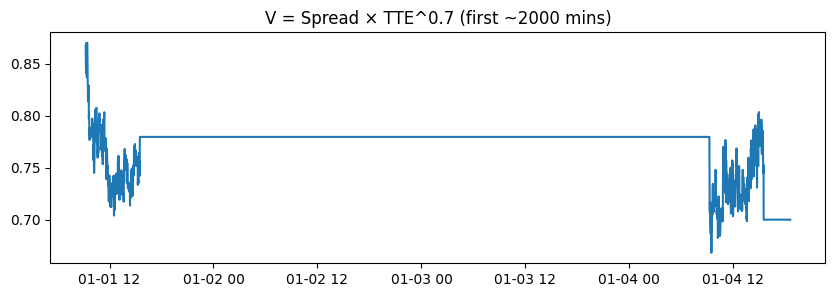

In [ ]:
plt.figure(figsize=(10,3))
plt.plot(features.index[:2000], features['V'].iloc[:2000])
plt.title("V = Spread × TTE^0.7 (first ~2000 mins)")
plt.show()


In [ ]:
window = 6 * 60
roll_mean = features['spread'].rolling(window).mean()
roll_std = features['spread'].rolling(window).std()
features['zscore'] = (features['spread'] - roll_mean) / roll_std
features[['spread','zscore']].head(10)


,spread,zscore
time,,
2021-01-01 09:15:00,0.086329,NaN
2021-01-01 09:16:00,0.084948,NaN
2021-01-01 09:17:00,0.084229,NaN
2021-01-01 09:18:00,0.086244,NaN
2021-01-01 09:19:00,0.086588,NaN
2021-01-01 09:20:00,0.084715,NaN
2021-01-01 09:21:00,0.083683,NaN
2021-01-01 09:22:00,0.085145,NaN
2021-01-01 09:23:00,0.083308,NaN


In [ ]:
W = 6 * 60
features['mu'] = features['spread'].rolling(W, min_periods=W).mean()
features['sd'] = features['spread'].rolling(W, min_periods=W).std()
features['z']  = (features['spread'] - features['mu']) / features['sd']
sig = features.dropna(subset=['z']).copy()
ENTRY, EXIT = 2.0, 0.5
EOD_FLAT = False
COST_PER_TURN = 0.0
sig['eod'] = (sig.index.time == pd.to_datetime("15:30").time())
def build_positions(df, entry=ENTRY, exit_=EXIT, eod_flat=EOD_FLAT):
    pos = 0
    out = []
    for t, r in df.iterrows():
        z = r['z']
        if pos == 0:
            if z > entry:
                pos = -1
            elif z < -entry:
                pos = +1
        else:
            if abs(z) < exit_:
                pos = 0
        if eod_flat and r['eod']:
            pos = 0
        out.append((t, pos))
    return pd.Series(dict(out)).sort_index()
sig['position'] = build_positions(sig)
def pnl_series(df, mode='delta', cost_per_turn=0.0):
    p = df['position'].astype(float)
    V = df['V'].astype(float)
    pnl = p.shift(1) * (V if mode=='level' else V.diff())
    pnl = pnl.fillna(0.0)
    turns = (p != p.shift(1)).fillna(False)
    pnl[turns] -= cost_per_turn
    return pnl
sig['pnl_A'] = pnl_series(sig, mode='level', cost_per_turn=COST_PER_TURN)
sig['pnl_B'] = pnl_series(sig, mode='delta', cost_per_turn=COST_PER_TURN)
sig['cum_A'] = sig['pnl_A'].cumsum()
sig['cum_B'] = sig['pnl_B'].cumsum()
import numpy as np
def sharpe(ret, ann_factor=252*6.25*60):
    r = ret.dropna()
    if r.std() == 0: return np.nan
    return (r.mean() / r.std()) * np.sqrt(ann_factor)
def max_dd(equity):
    roll_max = equity.cummax()
    dd = equity - roll_max
    return dd.min()
summary = {
    'Total PnL A (level)': sig['pnl_A'].sum(),
    'Sharpe A':            sharpe(sig['pnl_A']),
    'MaxDD A':             max_dd(sig['cum_A']),
    'Total PnL B (delta)': sig['pnl_B'].sum(),
    'Sharpe B':            sharpe(sig['pnl_B']),
    'MaxDD B':             max_dd(sig['cum_B']),
    'Trades':              int((sig['position'] != sig['position'].shift(1)).sum())
}
summary


{'Total PnL A (level)': np.float64(-563.7468725076668),
 'Sharpe A': np.float64(-2.0671364321268),
 'MaxDD A': -2956.493709852112,
 'Total PnL B (delta)': np.float64(105.87846788499746),
 'Sharpe B': np.float64(4.2350213517180375),
 'MaxDD B': -2.6787279733135563,
 'Trades': 3515}

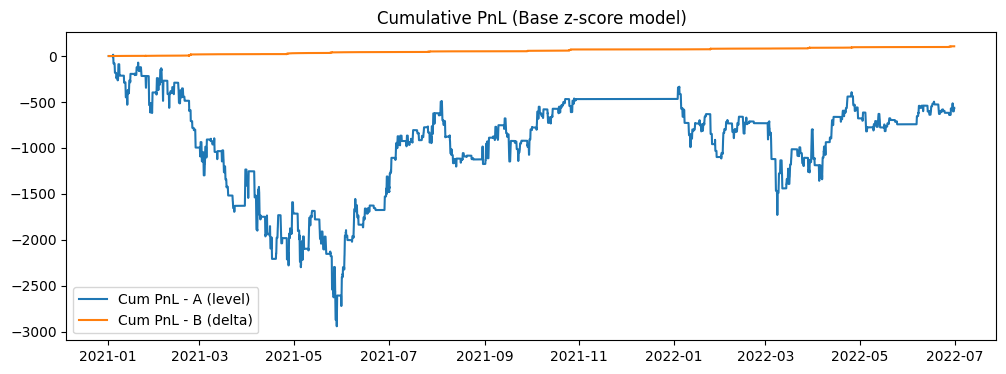

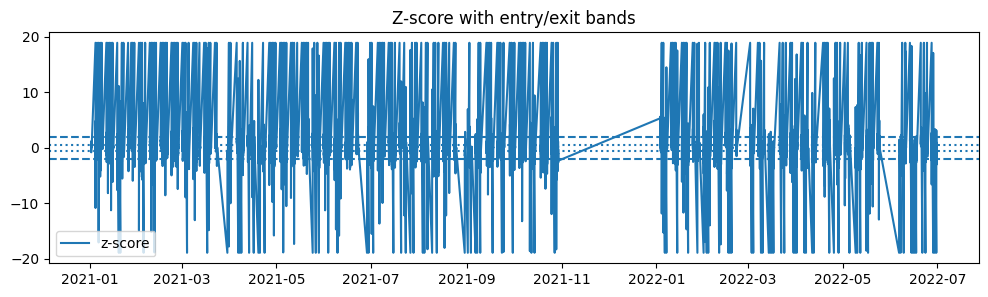

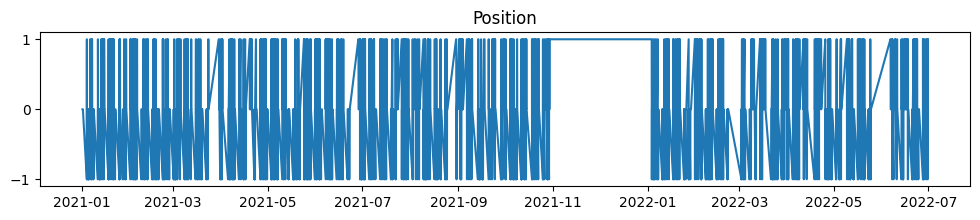

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(sig['cum_A'], label='Cum PnL - A (level)')
plt.plot(sig['cum_B'], label='Cum PnL - B (delta)')
plt.title("Cumulative PnL (Base z-score model)")
plt.legend(); plt.show()
plt.figure(figsize=(12,3))
plt.plot(sig['z'], label='z-score'); plt.axhline(ENTRY, ls='--'); plt.axhline(-ENTRY, ls='--')
plt.axhline(EXIT, ls=':'); plt.axhline(-EXIT, ls=':')
plt.title("Z-score with entry/exit bands"); plt.legend(); plt.show()
plt.figure(figsize=(12,2))
plt.plot(sig['position'])
plt.title("Position"); plt.yticks([-1,0,1]); plt.show()


In [ ]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
def build_positions_from_z(z, entry=2.0, exit_=0.5, eod_flat=False, index=None):
    pos = 0
    out_idx, out_pos = [], []
    for t, val in z.items():
        if np.isnan(val):
            pass
        else:
            if pos == 0:
                if val > entry:   pos = -1
                elif val < -entry: pos = +1
            else:
                if abs(val) < exit_:
                    pos = 0
        if eod_flat and (t.time() == pd.to_datetime("15:30").time()):
            pos = 0
        out_idx.append(t); out_pos.append(pos)
    s = pd.Series(out_pos, index=out_idx, name="position")
    if index is not None:
        s = s.reindex(index).fillna(method="ffill").fillna(0)
    return s
def pnl_series_delta(position, V, cost_per_turn=0.0):
    p = position.astype(float)
    pnl = p.shift(1) * V.diff()
    pnl = pnl.fillna(0.0)
    turns = (p != p.shift(1)).fillna(False)
    pnl[turns] -= cost_per_turn
    return pnl
def sharpe(ret, ann_factor=252*6.25*60):
    r = ret.dropna()
    if r.std() == 0: return np.nan
    return (r.mean() / r.std()) * np.sqrt(ann_factor)
def max_dd(equity):
    roll_max = equity.cummax()
    dd = equity - roll_max
    return dd.min()
windows   = [360, 390, 780, 1950]
entries   = [2.0, 2.5, 3.0]
exits     = [0.5, 1.0]
EOD_FLAT  = False
COST      = 0.0
results = []
for W, z_entry, z_exit in itertools.product(windows, entries, exits):
    df = features.copy()
    df['mu'] = df['spread'].rolling(W, min_periods=W).mean()
    df['sd'] = df['spread'].rolling(W, min_periods=W).std()
    df['z']  = (df['spread'] - df['mu']) / df['sd']
    df = df.dropna(subset=['z'])
    pos = build_positions_from_z(df['z'], entry=z_entry, exit_=z_exit, eod_flat=EOD_FLAT, index=df.index)
    pnl = pnl_series_delta(pos, df['V'], cost_per_turn=COST)
    cum = pnl.cumsum()
    res = dict(
        W=W, z_entry=z_entry, z_exit=z_exit,
        TotalPnL=float(pnl.sum()),
        Sharpe=float(sharpe(pnl)),
        MaxDD=float(max_dd(cum)),
        Trades=int((pos != pos.shift(1)).sum()),
        AvgHold=float((pos.groupby((pos != pos.shift()).cumsum()).transform('size')[pos!=0]).mean() or 0)
    )
    results.append(res)
grid = pd.DataFrame(results).sort_values(['Sharpe','TotalPnL'], ascending=False)
display(grid.head(10))


/tmp/ipython-input-3755100552.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = s.reindex(index).fillna(method="ffill").fillna(0)
/tmp/ipython-input-3755100552.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = s.reindex(index).fillna(method="ffill").fillna(0)
/tmp/ipython-input-3755100552.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = s.reindex(index).fillna(method="ffill").fillna(0)
/tmp/ipython-input-3755100552.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = s.reindex(index).fillna(method="ffill").fillna(0)
/tmp/ipython-input-3755100552.py:26: FutureWarning: Series.fillna with 'method' is deprecated an

,W,z_entry,z_exit,TotalPnL,Sharpe,MaxDD,Trades,AvgHold
7,390,2.0,1.0,164.504277,7.446908,-4.431526,4997,104.805116
1,360,2.0,1.0,155.792996,7.299021,-3.748711,4949,99.486532
9,390,2.5,1.0,120.792275,5.958633,-3.857799,3331,107.076983
3,360,2.5,1.0,108.356565,5.661072,-3.918098,3249,104.120376
13,780,2.0,1.0,170.041939,4.966158,-4.375439,5879,219.045827
15,780,2.5,1.0,148.631524,4.633767,-4.409930,4341,223.734558
11,390,3.0,1.0,83.244400,4.619841,-2.216078,2331,107.625434
5,360,3.0,1.0,78.646282,4.554914,-2.031373,2307,105.017959
19,1950,2.0,1.0,171.264773,4.554833,-5.187464,2861,743.565350
0,360,2.0,0.5,105.878468,4.235021,-2.678728,3515,203.391618


z_entry       2.0                 2.5                 3.0          
z_exit        0.5       1.0       0.5       1.0       0.5       1.0
W                                                                  
360      4.235021  7.299021  3.343332  5.661072  2.641455  4.554914
390      4.207266  7.446908  3.470305  5.958633  2.567495  4.619841
780      3.026102  4.966158  2.600302  4.633767  2.232227  3.990188
1950     2.334045  4.554833  2.104923  4.143512  1.799433  3.609699

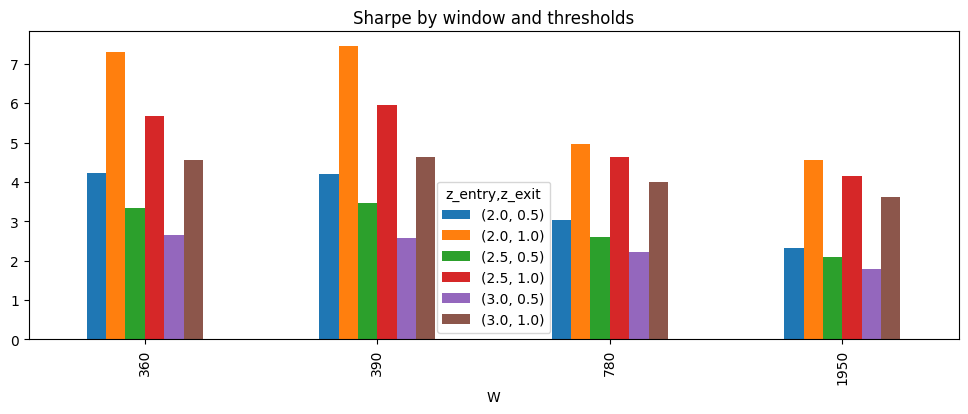

In [ ]:
pivot_sharpe = grid.pivot_table(index='W', columns=['z_entry','z_exit'], values='Sharpe')
display(pivot_sharpe)
pivot_sharpe.plot(kind='bar', figsize=(12,4), title="Sharpe by window and thresholds"); plt.show()


In [ ]:
features


,banknifty,nifty,tte,gap_min,gap_flag,banknifty_changed_by_ffill,nifty_changed_by_ffill,spread,V,zscore,mu,sd,z
time,,,,,,,,,,,,,
2021-01-01 09:15:00,0.286058,0.199729,27,1.0,small,False,False,0.086329,0.867184,NaN,NaN,NaN,NaN
2021-01-01 09:16:00,0.285381,0.200433,27,1.0,small,False,False,0.084948,0.853317,NaN,NaN,NaN,NaN
2021-01-01 09:17:00,0.284233,0.200004,27,1.0,small,False,False,0.084229,0.846089,NaN,NaN,NaN,NaN
2021-01-01 09:18:00,0.286104,0.199860,27,1.0,small,False,False,0.086244,0.866325,NaN,NaN,NaN,NaN
2021-01-01 09:19:00,0.285539,0.198951,27,1.0,small,False,False,0.086588,0.869786,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,1.0,small,False,False,0.025943,0.267320,0.020999,0.025903,0.001915,0.020999
2022-06-30 15:27:00,0.240875,0.216558,28,1.0,small,False,False,0.024317,0.250560,-0.828832,0.025903,0.001915,-0.828832
2022-06-30 15:28:00,0.242115,0.216794,28,1.0,small,False,False,0.025321,0.260910,-0.307274,0.025908,0.001911,-0.307274


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df0 = features.copy()
if 'spread' not in df0:
    df0['spread'] = df0['banknifty'] - df0['nifty']
if 'V' not in df0:
    df0['V'] = df0['spread'] * (df0['tte']**0.7)
MINS_PER_DAY = 375
def build_positions_from_signal(sig, z_in=2.0, z_out=1.0, min_hold=0, eod_flat=False):
    """Classic hysteresis: enter when |sig|>z_in, exit when |sig|<z_out.
       Decisions use sig at t-1 (enter on next bar). min_hold in minutes."""
    idx = sig.index
    pos = np.zeros(len(sig), dtype=int)
    held = 0
    for i in range(1, len(sig)):
        z = sig.iat[i-1]
        if held > 0: held -= 1
        if eod_flat and idx[i-1].time().strftime("%H:%M") == "15:30":
            pos[i] = 0
            held = 0
            continue
        cur = pos[i-1]
        if cur == 0:
            if np.isfinite(z) and z >  z_in:
                cur, held = -1, min_hold
            elif np.isfinite(z) and z < -z_in:
                cur, held = +1, min_hold
        else:
            if (np.isfinite(z) and abs(z) < z_out) and held == 0:
                cur = 0
        pos[i] = cur
    return pd.Series(pos, index=idx, name="position")
def pnl_delta(position, V, cost_per_flip=0.0):
    p = position.astype(float)
    dV = V.diff().fillna(0.0)
    pnl = p.shift(1).fillna(0.0) * dV
    turns = (p != p.shift(1)).fillna(False)
    if cost_per_flip:
        pnl[turns] -= cost_per_flip
    return pnl
def sharpe(x, ann=252*MINS_PER_DAY):
    r = x.dropna(); s = r.std(ddof=0)
    return 0 if s==0 else (r.mean()/s)*np.sqrt(ann)
def max_dd(equity):
    dd = equity - equity.cummax()
    return float(dd.min())
def evaluate_model(df, signal_col, name, z_in=2.0, z_out=1.0, min_hold=0, cost=0.0):
    pos = build_positions_from_signal(df[signal_col], z_in, z_out, min_hold=min_hold)
    pnl = pnl_delta(pos, df['V'], cost_per_flip=cost)
    cum = pnl.cumsum()
    stats = {
        "Model": name,
        "Sharpe": sharpe(pnl),
        "TotalPnL": float(pnl.sum()),
        "MaxDD": max_dd(cum),
        "Trades": int((pos != pos.shift(1)).sum()),
        "AvgHold(min)": float((pos.groupby((pos!=pos.shift()).cumsum()).transform('size')[pos!=0]).mean() or 0),
        "z_in": z_in, "z_out": z_out, "min_hold": min_hold, "cost": cost
    }
    return stats, pos, pnl, cum


In [ ]:
df = df0.copy()
half_life = 1.0 * MINS_PER_DAY
mu = df['spread'].ewm(halflife=half_life, adjust=False).mean()
sd = df['spread'].ewm(halflife=half_life, adjust=False).std(bias=False).replace(0, np.nan)
df['z_ewma'] = (df['spread'] - mu) / sd
stats_A, pos_A, pnl_A, cum_A = evaluate_model(df, 'z_ewma',
                                              name=f"EWMA z (hl={half_life:.0f}m)",
                                              z_in=2.0, z_out=1.0, min_hold=0, cost=0.0)
print(stats_A)


{'Model': 'EWMA z (hl=375m)', 'Sharpe': np.float64(1.9772876970675113), 'TotalPnL': 69.59411309024738, 'MaxDD': -3.985965981119924, 'Trades': 3495, 'AvgHold(min)': 200.6056050877887, 'z_in': 2.0, 'z_out': 1.0, 'min_hold': 0, 'cost': 0.0}


In [ ]:
df = df0.copy()
x = df['spread'].astype(float)
L = 5 * MINS_PER_DAY
x_lag = x.shift(1)
S_xlag  = x_lag.rolling(L).sum()
S_y     = x.rolling(L).sum()
S_xlag2 = (x_lag**2).rolling(L).sum()
S_xlagy = (x_lag * x).rolling(L).sum()
den = (S_xlag2 - (S_xlag**2)/L)
phi = (S_xlagy - (S_xlag*S_y)/L) / den
c   = (S_y - phi*S_xlag) / L
mu = c / (1 - phi)
eps = x - (c + phi*x_lag)
sig_eps = eps.rolling(L).std(ddof=0)
sig_stat = sig_eps / np.sqrt(1 - phi**2)
df['s_ou'] = (x - mu) / sig_stat
stats_B, pos_B, pnl_B, cum_B = evaluate_model(df, 's_ou',
                                              name=f"OU s-score (L={L}m)",
                                              z_in=2.0, z_out=1.0, min_hold=0, cost=0.0)
print(stats_B)


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


{'Model': 'OU s-score (L=1875m)', 'Sharpe': np.float64(2.1582615319240146), 'TotalPnL': 79.94226493462557, 'MaxDD': -4.543746405246045, 'Trades': 2799, 'AvgHold(min)': 519.9290141525652, 'z_in': 2.0, 'z_out': 1.0, 'min_hold': 0, 'cost': 0.0}


In [ ]:
df = df0.copy()
x = df['spread'].astype(float).values
roll_R_win = 2 * MINS_PER_DAY
R_series = pd.Series(df['spread']).diff().rolling(roll_R_win).std(ddof=0).pow(2)
R = np.nanmedian(R_series.dropna())
q_scale = 0.02
Q = q_scale * R
m = np.zeros_like(x)
P = np.zeros_like(x)
s = np.full_like(x, np.nan, dtype=float)
m[0] = x[0]
P[0] = 10*R
for t in range(1, len(x)):
    m_pred = m[t-1]
    P_pred = P[t-1] + Q
    S = P_pred + R
    K = P_pred / S
    m[t] = m_pred + K * (x[t] - m_pred)
    P[t] = (1 - K) * P_pred
    s[t] = (x[t] - m_pred) / np.sqrt(S)
df['s_kf'] = s
stats_C, pos_C, pnl_C, cum_C = evaluate_model(df, 's_kf',
                                              name=f"Kalman mean (q_scale={q_scale})",
                                              z_in=2.0, z_out=1.0, min_hold=0, cost=0.0)
print(stats_C)


{'Model': 'Kalman mean (q_scale=0.02)', 'Sharpe': np.float64(1.2657564935399874), 'TotalPnL': 65.99100916002274, 'MaxDD': -4.0114278265077115, 'Trades': 21872, 'AvgHold(min)': 17.418514109205574, 'z_in': 2.0, 'z_out': 1.0, 'min_hold': 0, 'cost': 0.0}


In [ ]:
df = df0.copy()
W = 390
mu = df['spread'].rolling(W, min_periods=W).mean()
sd = df['spread'].rolling(W, min_periods=W).std().replace(0, np.nan)
df['z_roll'] = (df['spread'] - mu) / sd
stats_base, pos_base, pnl_base, cum_base = evaluate_model(df, 'z_roll',
                                                          name=f"Baseline rolling z (W={W})",
                                                          z_in=2.0, z_out=1.0, min_hold=0, cost=0.0)
print(stats_base)


{'Model': 'Baseline rolling z (W=390)', 'Sharpe': np.float64(2.2189214883624486), 'TotalPnL': 69.55842822237979, 'MaxDD': -3.80384491694745, 'Trades': 4997, 'AvgHold(min)': 104.80511575096196, 'z_in': 2.0, 'z_out': 1.0, 'min_hold': 0, 'cost': 0.0}


,Sharpe,TotalPnL,MaxDD,Trades,AvgHold(min),z_in,z_out,min_hold,cost
Model,,,,,,,,,
Baseline rolling z (W=390),2.218921,69.558428,-3.803845,4997,104.805116,2.0,1.0,0,0.0
OU s-score (L=1875m),2.158262,79.942265,-4.543746,2799,519.929014,2.0,1.0,0,0.0
EWMA z (hl=375m),1.977288,69.594113,-3.985966,3495,200.605605,2.0,1.0,0,0.0
Kalman mean (q_scale=0.02),1.265756,65.991009,-4.011428,21872,17.418514,2.0,1.0,0,0.0


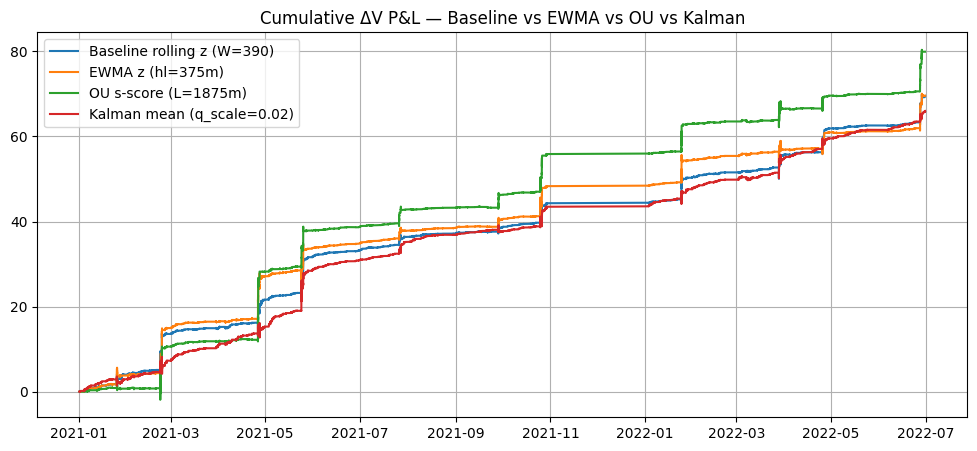

In [ ]:
summary = pd.DataFrame([stats_base, stats_A, stats_B, stats_C]).set_index("Model")
display(summary.sort_values("Sharpe", ascending=False))
plt.figure(figsize=(12,5))
plt.plot(cum_base, label=stats_base['Model'])
plt.plot(cum_A,    label=stats_A['Model'])
plt.plot(cum_B,    label=stats_B['Model'])
plt.plot(cum_C,    label=stats_C['Model'])
plt.title("Cumulative ΔV P&L — Baseline vs EWMA vs OU vs Kalman")
plt.legend(); plt.grid(True); plt.show()


In [ ]:
import numpy as np, pandas as pd
df = features.copy()
MINS_PER_DAY = 375
W = 390
mu_roll = df['spread'].rolling(W, min_periods=W).mean()
sd_roll = df['spread'].rolling(W, min_periods=W).std().replace(0,np.nan)
df['sig_base'] = (df['spread'] - mu_roll) / sd_roll
hl = 1.0 * MINS_PER_DAY
mu_ewm = df['spread'].ewm(halflife=hl, adjust=False).mean()
sd_ewm = df['spread'].ewm(halflife=hl, adjust=False).std(bias=False).replace(0,np.nan)
df['sig_ewma'] = (df['spread'] - mu_ewm) / sd_ewm
L = 5 * MINS_PER_DAY
x = df['spread'].astype(float); xlag = x.shift(1)
Sx  = xlag.rolling(L).sum();   Sy  = x.rolling(L).sum()
Sxx = (xlag**2).rolling(L).sum(); Sxy = (xlag*x).rolling(L).sum()
den = (Sxx - (Sx**2)/L)
phi = (Sxy - (Sx*Sy)/L) / den
c   = (Sy - phi*Sx) / L
mu  = c / (1 - phi)
eps = x - (c + phi*xlag)
sig_eps = eps.rolling(L).std(ddof=0)
sig_stat = sig_eps / np.sqrt(1 - phi**2)
df['sig_ou'] = (x - mu) / sig_stat
def kf_signal(spread, q_scale=0.02):
    x = spread.astype(float).values
    R_series = spread.diff().rolling(2*MINS_PER_DAY).std(ddof=0).pow(2)
    R = float(np.nanmedian(R_series.dropna()))
    Q = q_scale * R
    m = np.zeros_like(x); P = np.zeros_like(x); s = np.full_like(x, np.nan, float)
    m[0] = x[0]; P[0] = 10*R
    for t in range(1,len(x)):
        m_pred, P_pred = m[t-1], P[t-1]+Q
        S = P_pred + R; K = P_pred / S
        m[t] = m_pred + K*(x[t]-m_pred)
        P[t] = (1-K)*P_pred
        s[t] = (x[t]-m_pred)/np.sqrt(S)
    return pd.Series(s, index=spread.index)
df['sig_kf_002'] = kf_signal(df['spread'], q_scale=0.02)
df['sig_kf_001'] = kf_signal(df['spread'], q_scale=0.01)


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
def run_model(signal, V, z_in=2.0, z_out=1.0, min_hold=0, cost=0.0):
    sig = signal.values
    Vv  = V.values
    n = len(sig)
    pos = np.zeros(n, dtype=np.int8)
    hold = 0
    for i in range(1, n):
        z = sig[i-1]
        if hold>0: hold -= 1
        cur = pos[i-1]
        if cur == 0:
            if np.isfinite(z) and z >  z_in: cur, hold = -1, min_hold
            elif np.isfinite(z) and z < -z_in: cur, hold = +1, min_hold
        else:
            if np.isfinite(z) and abs(z) < z_out and hold==0: cur = 0
        pos[i] = cur
    dV  = np.diff(Vv, prepend=Vv[0])
    pnl = np.roll(pos, 1) * dV
    turns = pos != np.roll(pos, 1); turns[0] = False
    if cost: pnl[turns] -= cost
    cum = pnl.cumsum()
    def sharpe(x):
        r = x[np.isfinite(x)]
        s = r.std()
        return 0 if s==0 else (r.mean()/s)*np.sqrt(252*MINS_PER_DAY)
    def maxdd(eq):
        rm = np.maximum.accumulate(eq)
        return float((eq - rm).min())
    return {
        "Sharpe": sharpe(pnl),
        "TotalPnL": float(pnl.sum()),
        "MaxDD": maxdd(cum),
        "Trades": int(turns.sum()),
        "AvgHold(min)": float( np.mean(np.diff(np.where(np.concatenate(([True], turns, [True])))[0])[1::2]) if turns.any() else 0)
    }, pnl, cum


In [ ]:
configs = [
    ("Baseline z W=390", df['sig_base']),
    ("EWMA z hl=375m",   df['sig_ewma']),
    ("OU s-score L=1875m", df['sig_ou']),
    ("Kalman q=0.02",    df['sig_kf_002']),
    ("Kalman q=0.01",    df['sig_kf_001']),
]
z_in, z_out = 2.0, 1.0
rows = []
curves = {}
for name, sig in configs:
    for min_hold in [0, 15]:
        for cost in [0.0, 0.00005]:
            stats, pnl, cum = run_model(sig.dropna(), df.loc[sig.dropna().index, 'V'],
                                        z_in=z_in, z_out=z_out, min_hold=min_hold, cost=cost)
            stats.update({"Model": name, "min_hold": min_hold, "cost": cost})
            rows.append(stats)
            curves[(name, min_hold, cost)] = cum
summary = pd.DataFrame(rows).sort_values(["Sharpe","TotalPnL"], ascending=False)
display(summary.head(10))


,Sharpe,TotalPnL,MaxDD,Trades,AvgHold(min),Model,min_hold,cost
0,3.171606,69.558428,-3.803845,4996,25.385108,Baseline z W=390,0,0.00000
1,3.160191,69.308628,-3.804245,4996,25.385108,Baseline z W=390,0,0.00005
8,2.252308,79.800075,-4.536289,2798,76.504646,OU s-score L=1875m,0,0.00000
9,2.248353,79.660175,-4.540889,2798,76.504646,OU s-score L=1875m,0,0.00005
4,1.977290,69.594113,-3.985966,3494,37.622210,EWMA z hl=375m,0,0.00000
5,1.972313,69.419413,-3.991766,3494,37.622210,EWMA z hl=375m,0,0.00005
2,1.510844,41.414510,-4.188726,3302,44.192611,Baseline z W=390,15,0.00000
3,1.504817,41.249410,-4.191326,3302,44.192611,Baseline z W=390,15,0.00005
16,1.347866,70.160252,-4.301122,20967,6.511446,Kalman q=0.01,0,0.00000
17,1.327726,69.111902,-4.302622,20967,6.511446,Kalman q=0.01,0,0.00005


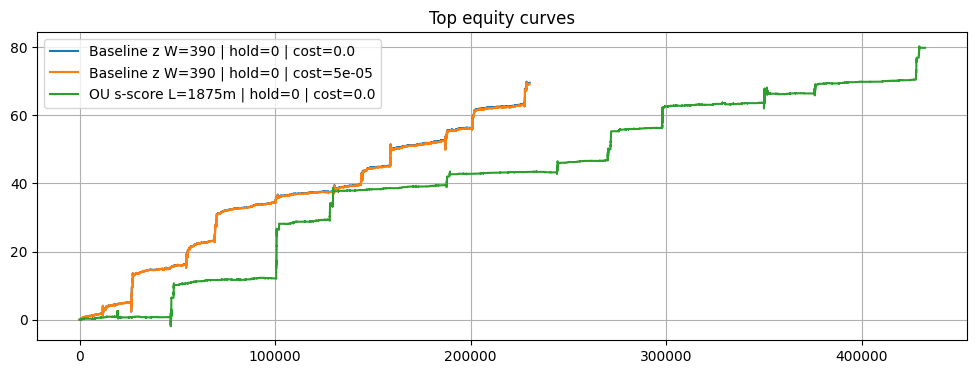

In [ ]:
top3 = summary.head(3)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
for _, r in top3.iterrows():
    k = (r["Model"], r["min_hold"], r["cost"])
    plt.plot(curves[k], label=f'{r["Model"]} | hold={r["min_hold"]} | cost={r["cost"]}')
plt.title("Top equity curves"); plt.legend(); plt.grid(True); plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = summary.copy()
df["Risk"] = -df["MaxDD"]
def pareto_mask(df, maximize=("Sharpe","TotalPnL"), minimize=("Risk",)):
    X = np.column_stack([df[list(maximize)].values,
                         -df[list(minimize)].values])
    n = X.shape[0]
    is_eff = np.ones(n, dtype=bool)
    for i in range(n):
        if not is_eff[i]:
            continue
        dominates = np.all(X >= X[i], axis=1) & np.any(X > X[i], axis=1)
        dominates[i] = False
        if dominates.any():
            is_eff[i] = False
    return is_eff
mask = pareto_mask(df)
front = df[mask].sort_values(["Risk","Sharpe","TotalPnL"], ascending=[True,False,False])


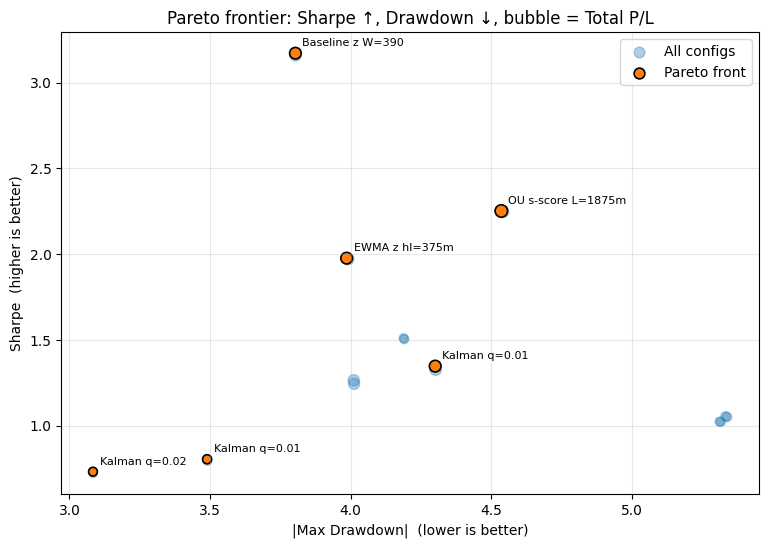

In [ ]:
plt.figure(figsize=(9,6))
plt.scatter(df["Risk"], df["Sharpe"], s=np.clip(df["TotalPnL"], 20, 200),
            alpha=0.35, label="All configs")
plt.scatter(front["Risk"], front["Sharpe"], s=np.clip(front["TotalPnL"], 40, 260),
            edgecolor="k", linewidths=1.2, label="Pareto front")
for _, r in front.iterrows():
    plt.annotate(r["Model"], (r["Risk"], r["Sharpe"]), xytext=(5,5),
                 textcoords="offset points", fontsize=8)
plt.xlabel("|Max Drawdown|  (lower is better)")
plt.ylabel("Sharpe  (higher is better)")
plt.title("Pareto frontier: Sharpe ↑, Drawdown ↓, bubble = Total P/L")
plt.grid(True, alpha=0.3); plt.legend()
plt.show()
